In [1]:
import righor
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
import numpy as np

# set the number of threads
# (by default all of them, can only be set once)
righor.set_number_threads(2)
# set if running in a notebook
righor.notebook_mode()

# useful if there's a weird error
import os
os.environ["RUST_BACKTRACE"] = "1"

# load the model
igor_model = righor.load_model("human", "trb")
# alternatively, you can load a model from igor files 
# igor_model = righor.load_model_from_files(params.txt, marginals.txt, anchor_v.csv, anchor_j.csv)

# constant error: all sequences have the same number of errors, here no errors
igor_model.error = righor.ErrorParameters.constant_error(0.0)
# uniform error: the number of error in the sequence is sequence-specific
# and inferred using the V gene (useful for sequences that undergo somatic hypermutation)
# igor_model.error = righor.ErrorParameters.uniform_error()
igor_model.model_type = righor.ModelStructure.VDJ

In [178]:
model = righor.Model.sample_model_vdj()
new_j = model.j_segments[0]
#new_j.seq = righor.Dna("AAAAAACAGTCTTCGGAGAAACAAAGACTTAT")
model.j_segments = [new_j]
model.d_segments = model.d_segments[:1]
model.p_ins_vd = np.array([0., 0., 1.])
model.p_ins_dj = np.array([0., 0., 1.])
model.p_del_d5_del_d3 = model.p_del_d5_del_d3[:, :, 0].sum(axis=0)[None,:,None]
model.markov_coefficients_dj = np.ones((4,4))
model.markov_coefficients_vd = np.ones((4,4))
model.range_del_d3 = (-1, 3)
model.range_del_d5 = (0, 0)
generator = model.generator(seed=None)
sequences = [generator.generate(False).full_seq for _ in range(10000)]
align_params = righor.AlignmentParameters()
infer_params = righor.InferenceParameters()

# multiple round of expectation-maximization to infer the model
models = {}
models[0] = model.copy().uniform()
for ii in range(30):
    models[ii+1] = models[ii].copy()
    models[ii+1].infer(sequences,
                       align_params,
                       infer_params)


(0.24, 0.26)

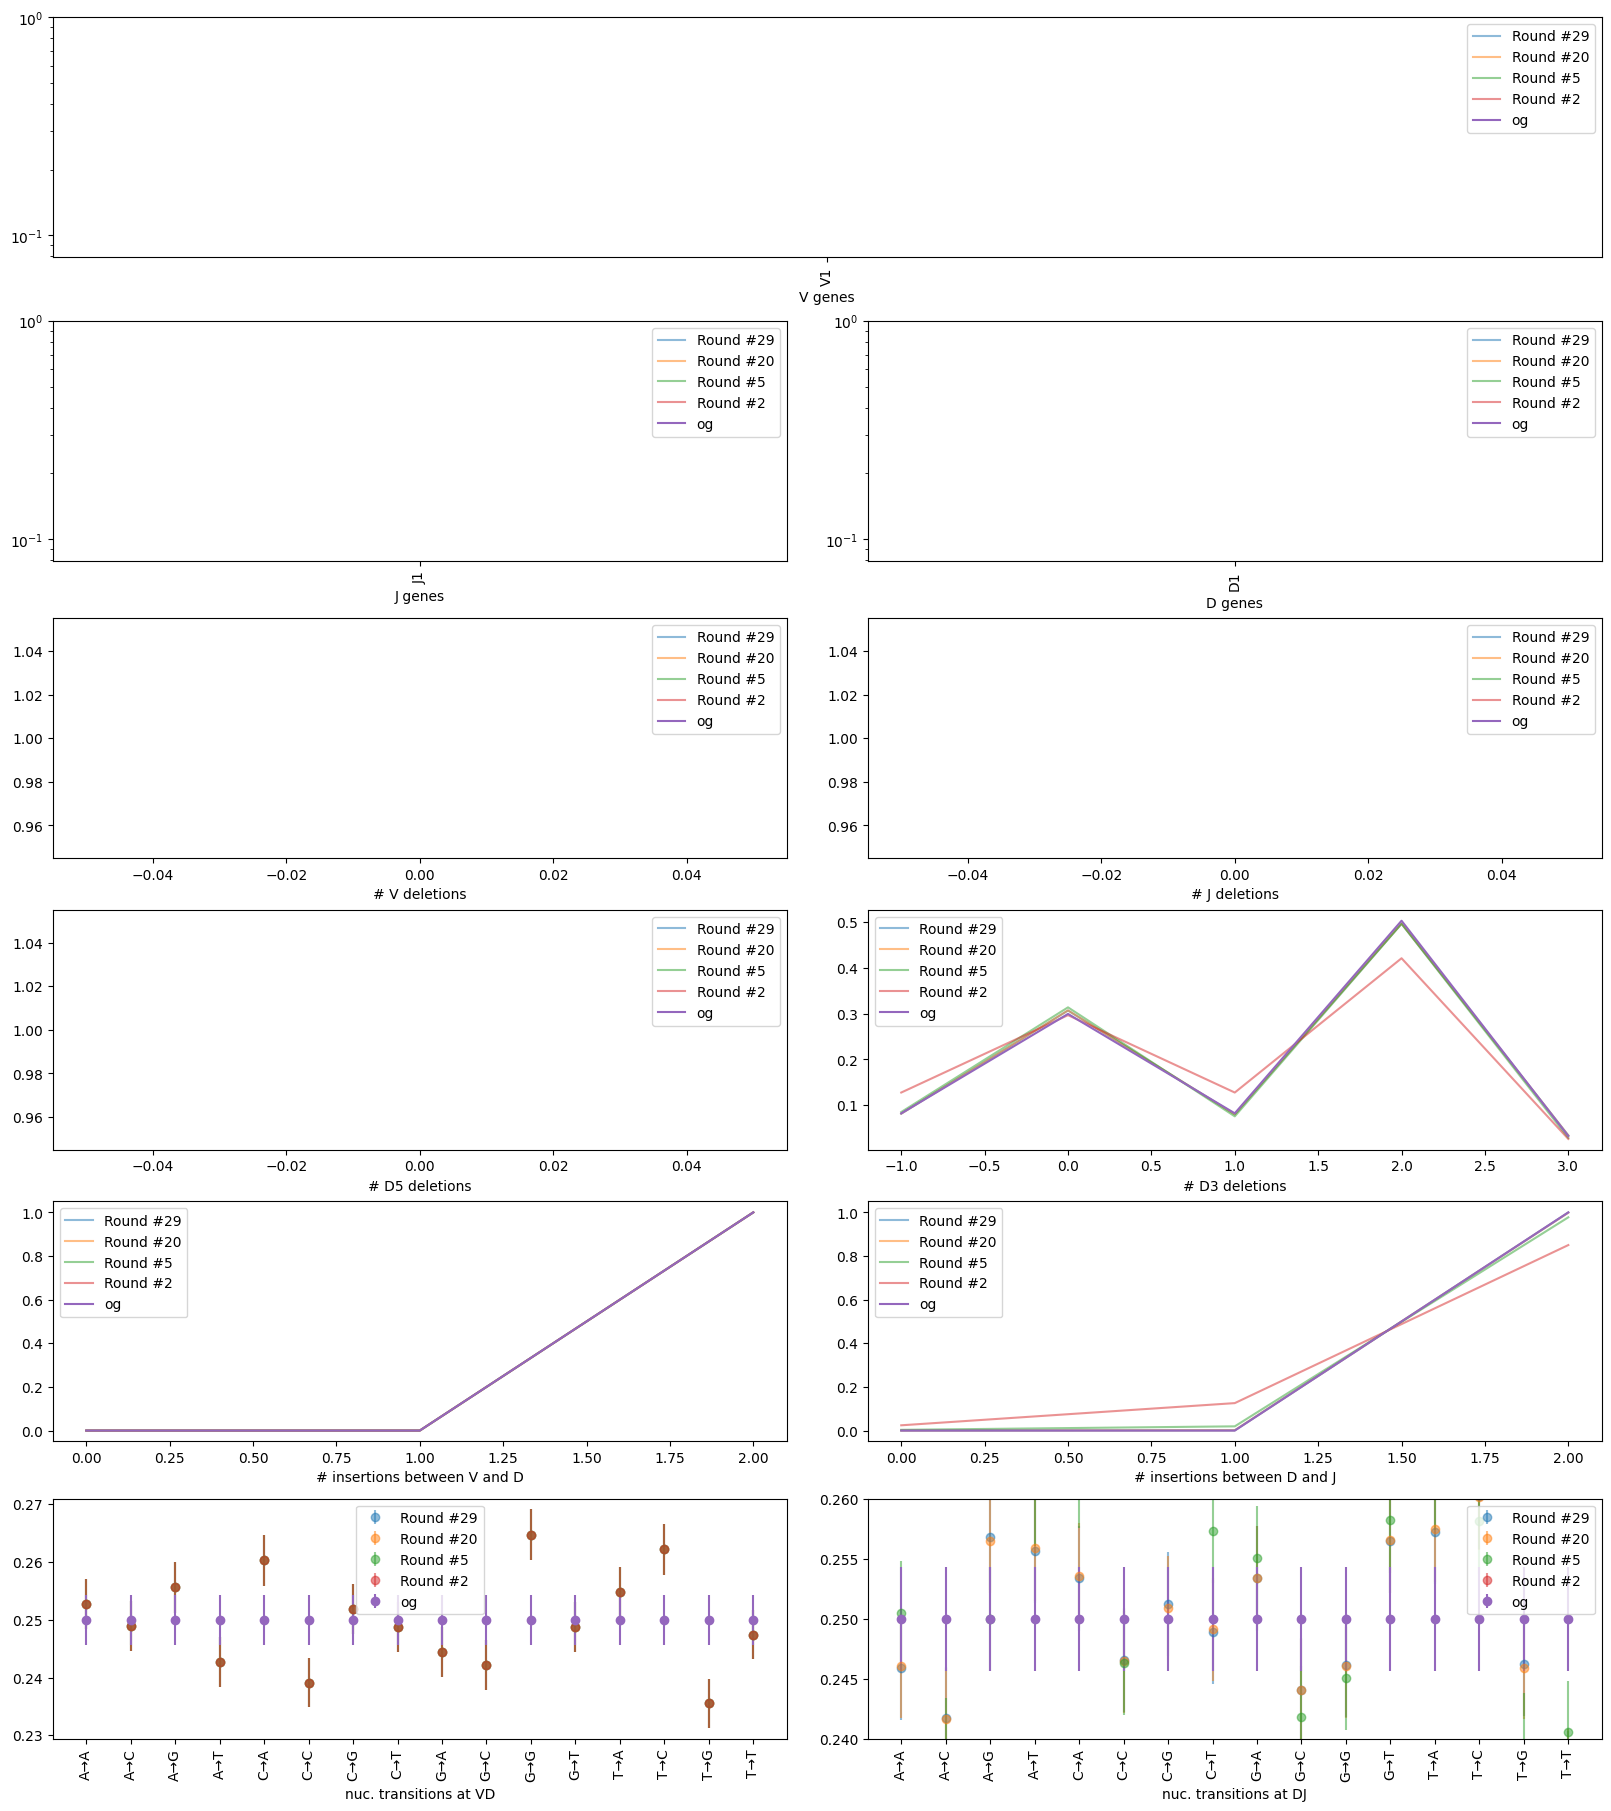

In [182]:
# visualisation of the results
fig = righor.plot_vdj(*[models[ii] for ii in [29,20,5,2]] + [model], n_sequences=10000,
            plots_kws=[{'label':f'Round #{ii}', 'alpha':0.5} for ii in [29,20,5,2]] + [{'label':f'og'}] )
fig.get_axes()[-1].set_ylim((0.24, 0.26))
#np.sqrt(model.markov_coefficients_dj*(1-model.markov_coefficients_dj)/10000).flatten())

In [134]:
np.sqrt(model.markov_coefficients_dj*(1-model.markov_coefficients_dj)/100000)

array([[0.00136931, 0.00136931, 0.00136931, 0.00136931],
       [0.00136931, 0.00136931, 0.00136931, 0.00136931],
       [0.00136931, 0.00136931, 0.00136931, 0.00136931],
       [0.00136931, 0.00136931, 0.00136931, 0.00136931]])

In [138]:
np.mean([np.abs(a) for a in (models[1].markov_coefficients_dj - model.markov_coefficients_dj).flatten() if np.abs(a) < 0.2])

np.float64(0.059242538986194956)

In [122]:
0.00136931*np.sqrt(2/3.14)

np.float64(0.0010928283517703597)

In [121]:
np.mean(np.abs(models[1].markov_coefficients_dj - model.markov_coefficients_dj))

np.float64(0.0020434027517711537)

In [165]:
rng = np.random.default_rng()

lst = rng.choice(range(4), size=100000)
dct = Counter(lst)
np.mean([np.abs(dct[ii]/100000 - 1/4) for ii in range(4)])

np.float64(0.0011150000000000049)

In [13]:
Counter([generator.generate(False).recombination_event.deld5 for _ in range(10000)])

Counter({0: 10000})

In [32]:
models[5].p_del_d5_del_d3.sum(axis=(1)),model.p_del_d5_del_d3.sum(axis=(1))

(array([[0.29764667, 0.332666  , 0.3498452 ],
        [0.27742791, 0.2012012 , 0.32404541],
        [0.42492542, 0.4661328 , 0.32610939]]),
 array([[0.2962963 , 0.33110687, 0.33333333],
        [0.28431373, 0.20610687, 0.33333333],
        [0.41938998, 0.46278626, 0.33333333]]))

In [24]:
from tqdm.notebook import tqdm
Counter([len(generator.generate(False).full_seq) for _ in tqdm(range(100000))])

  0%|          | 0/100000 [00:00<?, ?it/s]

Counter({74: 60028, 76: 30012, 75: 9960})

In [15]:
from tqdm.notebook import tqdm
Counter([(generator.generate(False).recombination_event.insdj.get_string()).count('C') for _ in tqdm(range(100000))])

  0%|          | 0/100000 [00:00<?, ?it/s]

Counter({0: 61210, 1: 32742, 2: 6048})

In [17]:
1.*model.markov_coefficients_dj[2,1]*model.markov_coefficients_dj[1,1],\
1.*(model.markov_coefficients_dj[2,0]*model.markov_coefficients_dj[0,1]+\
model.markov_coefficients_dj[2,2]*model.markov_coefficients_dj[2,1]+\
model.markov_coefficients_dj[2,3]*model.markov_coefficients_dj[3,1]+\
model.markov_coefficients_dj[2,1]*model.markov_coefficients_dj[1,0]+\
model.markov_coefficients_dj[2,1]*model.markov_coefficients_dj[1,2]+\
model.markov_coefficients_dj[2,1]*model.markov_coefficients_dj[1,3])+\
model.markov_coefficients_dj[2,1]*0.

(np.float64(0.06), np.float64(0.3275))

In [21]:
1 - 0.06 - 0.3275

0.6124999999999999

In [48]:
generator = model.generator(seed=40)
sequences = [generator.generate(False).full_seq for _ in tqdm(range(100000))]
results = [model.evaluate(s) for s in tqdm(sequences)]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [38]:

Counter([a.best_event.ins_dj.get_string().count('AA') for a in results])

Counter({0: 92357, 1: 7643})

In [37]:
from tqdm.notebook import tqdm
generator1 = models[1].generator(seed=40)
Counter([(generator1.generate(False).recombination_event.insdj.get_string()).count('C') for _ in tqdm(range(100000))])

  0%|          | 0/100000 [00:00<?, ?it/s]

Counter({0: 61797, 1: 32162, 2: 6041})

In [42]:
m = models[1]
m.markov_coefficients_dj[2, 0]*m.markov_coefficients_dj[0, 0]

np.float64(0.07717260827983498)

In [53]:
m = model.copy()
x = 2
m.p_del_d5_del_d3.sum(axis=(1))[x, 1] * m.p_vdj.sum(axis=(0, 2))[1] \
+ m.p_del_d5_del_d3.sum(axis=(1))[x, 2] * m.p_vdj.sum(axis=(0, 2))[2]

np.float64(0.17216921119592876)

In [56]:
m = model.copy()
x = 2
m.p_del_d5_del_d3.sum(axis=(1))[x, 0] * m.p_vdj.sum(axis=(0, 2))[0] 

np.float64(0.25163398692810457)

In [2]:
nt_sequence = 'TGTGCCAGCAGGAAGAGAAGGGTAACCGTGGTGTCACCCCTCCACTTT'
aa_sequence = righor.n_to_aa(nt_sequence)
vgenes = righor.genes_matching('TRBV11-3*01', igor_model)
jgenes = righor.genes_matching('TRBJ1-6*02', igor_model)

result_inference = igor_model.evaluate((nt_sequence, 
                                        vgenes, jgenes))
print(f"For the nucleotide sequence: {nt_sequence}")
print(result_inference)

# You can also access the most likely recombination event
print("Most likely recombination event: ")
event = result_inference.best_event
print(f"\tInsertion (VD): {event.ins_vd}")
print(f"\tInsertion (DJ): {event.ins_dj}")
print(f"\tD gene: {result_inference.best_d_gene}")
# more interestingly the "reconstructed sequence" without errors
print(f"\tReconstructed sequence:\n{result_inference.reconstructed_sequence}")



# all this also works with amino-acid sequences
print(f"\nFor the amino-acid sequence: {aa_sequence}")
result_inference = igor_model.evaluate((righor.AminoAcid(aa_sequence), 
                                        vgenes,
                                        jgenes))
print(result_inference)
print(f"\tReconstructed sequence:\n{result_inference.reconstructed_sequence}")

For the nucleotide sequence: TGTGCCAGCAGGAAGAGAAGGGTAACCGTGGTGTCACCCCTCCACTTT
Result:
	Likelihood: 1.08e-20, pgen: 1.08e-20
	Most likely event:
	- Junction (nucleotides): TGTGCCAGCAGGAAGAGAAGGGTAACCGTGGTGTCACCCCTCCACTTT 
	- Junction (amino acids): CASRKRRVTVVSPLHF 
	- V name: TRBV11-3*01 
	- J name: TRBJ1-6*02 
	- likelihood ratio: 0.33989368026807326 
 
Most likely recombination event: 
	Insertion (VD): Dna(GAAGAGA)
	Insertion (DJ): Dna(TAACCGTGGTG)
	D gene: TRBD1*01
	Reconstructed sequence:
GAAGCTGGAGTGGTTCAGTCTCCCAGATATAAGATTATAGAGAAAAAACAGCCTGTGGCTTTTTGGTGCAATCCTATTTCTGGCCACAATACCCTTTACTGGTACCTGCAGAACTTGGGACAGGGCCCGGAGCTTCTGATTCGATATGAGAATGAGGAAGCAGTAGACGATTCACAGTTGCCTAAGGATCGATTTTCTGCAGAGAGGCTCAAAGGAGTAGACTCCACTCTCAAGATCCAGCCTGCAGAGCTTGGGGACTCGGCCGTGTATCTCTGTGCCAGCAGGAAGAGAAGGGTAACCGTGGTGTCACCCCTCCACTTTGGGAACGGGACCAGGCTCACTGTGACAG

For the amino-acid sequence: CASRKRRVTVVSPLHF
Result:
	Likelihood: 6.65e-16, pgen: 6.65e-16
	Most likely event:
	- Junction (nucleotides): TGYGCNWSNMGN

In [3]:
## Generate sequences

# Create a generator object
generator = igor_model.generator(seed=42) # or igor_model.generator() to run it without a seed

# Generate 10'000 functional sequences (not out-of-frame, no stop codons, right boundaries)
for _ in tqdm(range(10000)):
    # generate_without_errors ignore Igor error model, use "generate" if this is needed
    sequence = generator.generate_without_errors(functional=True)
    if "IGH" in sequence.cdr3_aa:
        print("TRB CDR3 containing \"IGH\":", sequence.cdr3_aa)

print()

# Generate one sequence with a particular V/J genes family 
V_genes = righor.genes_matching("TRBV2", igor_model) # return all the V genes that match TRBV2
J_genes = righor.genes_matching("TRBJ", igor_model) # all the J genes
generator = igor_model.generator(seed=40, available_v=V_genes, available_j=J_genes) 
generation_result = generator.generate(functional=True)
print("Result:")
print(generation_result)
print("Explicit recombination event:")
print(generation_result.recombination_event)

  0%|          | 0/10000 [00:00<?, ?it/s]

TRB CDR3 containing "IGH": CASSMYLRDIGHTQYF
TRB CDR3 containing "IGH": CASSEKGGGQIGHSYEQYF

Result:
GenerationResult(
Junction (nucletides): TGTGCCAGCCGACGGACAGATAACTATGGATACAGCTTG,
Junction (amino-acids): CASRRTDNYGYSL,
Full sequence (nucleotides): CAACCTCACGTCACCCAGACTCCCAGCCCT...,
V gene: TRBV2*01,
J gene: TRBJ1-2*01)
		 
Explicit recombination event:
StaticEvent(
nb. del. on V3: 12,
nb. del. on D5: 6,
nb. del. on D3: 9,
nb. del. on J5: 4,
V-D insertions: CGACG,
D-J insertions: ,
errors: S0CS6CS8CS28CS33AS42GS51AS55GS62TS65TS68CS74GS82TS91GS97CS98CS100CS125TS127AS132GS134GS138TS140AS144GS157GS166GS174TS186CS201CS240AS243TS250CS255AS267CS269TS292AS302AS307GS311GS312TS322GS334A)


In [2]:
## Evaluate a given sequence
%env RUST_BACKTRACE=1
my_sequence = "GGGCCCGGAGCTTCTGATTCGATATGAGAATGAGGAAGCAGTAGACGATTCACAGTTGCCTAAGGATCGATTTTCTGCAGAGAGGCTCAAAGGAGTAGACTCCACTCTCAAGATCCAGCCTGCAGAGCTTGGGGACTCGGCCGTGTATCTCTGTGCCAGCAGGAAGAGAAGGGTAACCGTGGTGTCACCCCTCCACTTTGGGAACGGGACCA"

# evaluate the sequence
result_inference = igor_model.evaluate(my_sequence)

# Most likely scenario
best_event = result_inference.best_event
print(result_inference)

print(f"Probability that this specific event chain created the sequence: {best_event.likelihood / result_inference.likelihood:.2f}.")
print(f"Reconstructed sequence (without errors):", best_event.reconstructed_sequence)
print(f"Pgen: {result_inference.pgen:.1e}")

env: RUST_BACKTRACE=1
Result:
	Likelihood: 4.57e-76, pgen: 6.45e-16
	Most likely event:
	- Junction (nucleotides): TGTGCCAGCAGGAAGAGAAGGGTAACCGTGGTGTCACCCCTCCACTTT 
	- Junction (amino acids): CASRKRRVTVVSPLHF 
	- V name: TRBV11-3*01 
	- J name: TRBJ1-6*02 
	- likelihood ratio: 0 
 
Probability that this specific event chain created the sequence: 0.00.
Reconstructed sequence (without errors): Dna(GAAGCTGGAGTGGTTCAGTCTCCCAGATATAAGATTATAGAGAAAAAACAGCCTGTGGCTTTTTGGTGCAATCCTATTTCTGGCCACAATACCCTTTACTGGTACCTGCAGAACTTGGGACAGGGCCCGGAGCTTCTGATTCGATATGAGAATGAGGAAGCAGTAGACGATTCACAGTTGCCTAAGGATCGATTTTCTGCAGAGAGGCTCAAAGGAGTAGACTCCACTCTCAAGATCCAGCCTGCAGAGCTTGGGGACTCGGCCGTGTATCTCTGTGCCAGCAGCAAGACAGGGGTAACCGTGGATTCACCCCTCCACTTTGGGAACGGGACCAGGCTCACTGTGACAG)
Pgen: 6.5e-16


In [15]:
igor_model.p_del_d5_del_d3.shape

(2, 1, 3)

In [6]:
# Inference of a model 
# to keep this short we are artifically reducing the number of genes
# and reducing the number of insertions
igor_model_1 = righor.load_model("human", "trb")
igor_model = igor_model.sample_model_vdj()
igor_model.error = righor.ErrorParameters.constant_error(0.)
igor_model.model_type = righor.ModelStructure.VDJ
#igor_model.v_segments = [igor_model.v_segments[0]]
#igor_model.j_segments = [igor_model.j_segments[0]]
igor_model.d_segments = igor_model_1.d_segments
igor_model.p_ins_vd = np.array([1.])
igor_model.p_ins_dj = np.array([1.])
#igor_model.markov_coefficients_dj = igor_model_1.markov_coefficients_dj
#igor_model.markov_coefficients_vd = igor_model_1.markov_coefficients_vd
#igor_model.p_del_v_given_v = np.array([[1.]])
#igor_model.p_del_j_given_j = np.array([[1.]])
igor_model.p_del_d5_del_d3 = igor_model_1.p_del_d5_del_d3 # np.array([[[1.,1.,1.]]])
igor_model.range_del_d3 =  igor_model_1.range_del_d3
igor_model.range_del_d5 =  igor_model_1.range_del_d5 # (0,0)
#igor_model.range_del_v = (0, 0)
#igor_model.range_del_j = (0, 0)
# a good inference with all genes would take ≈ 10'000 sequences and a few hours on a laptop 
# (don't do it on a laptop)


# here we just generate the sequences needed
generator = igor_model.generator()
example_seq = generator.generate(False)
sequences = [generator.generate(False).full_seq for _ in range(10000)]

align_params = righor.AlignmentParameters()
infer_params = righor.InferenceParameters()
# define parameters for the alignment and the inference 
# (can also be done for the evaluation)
# the default are generally fine
# longer V gene cut-off improve the alignment but slower
# define the likelihood cutoff (higher: less precise but faster)
# infer_params.min_ratio_likelihood = 1e-4
# infer_params.min_likelihood = 1e-20

# generate an uniform model as a starting point 
# (it's generally much better to use an already inferred model as the starting point)
model = igor_model.copy().uniform()
model.error = righor.ErrorParameters.constant_error(0.)

# multiple round of expectation-maximization to infer the model
models = {}
models[0] = model
for ii in range(6):
    models[ii+1] = models[ii].copy()
    models[ii+1].infer(sequences,
                       align_params,
                       infer_params)

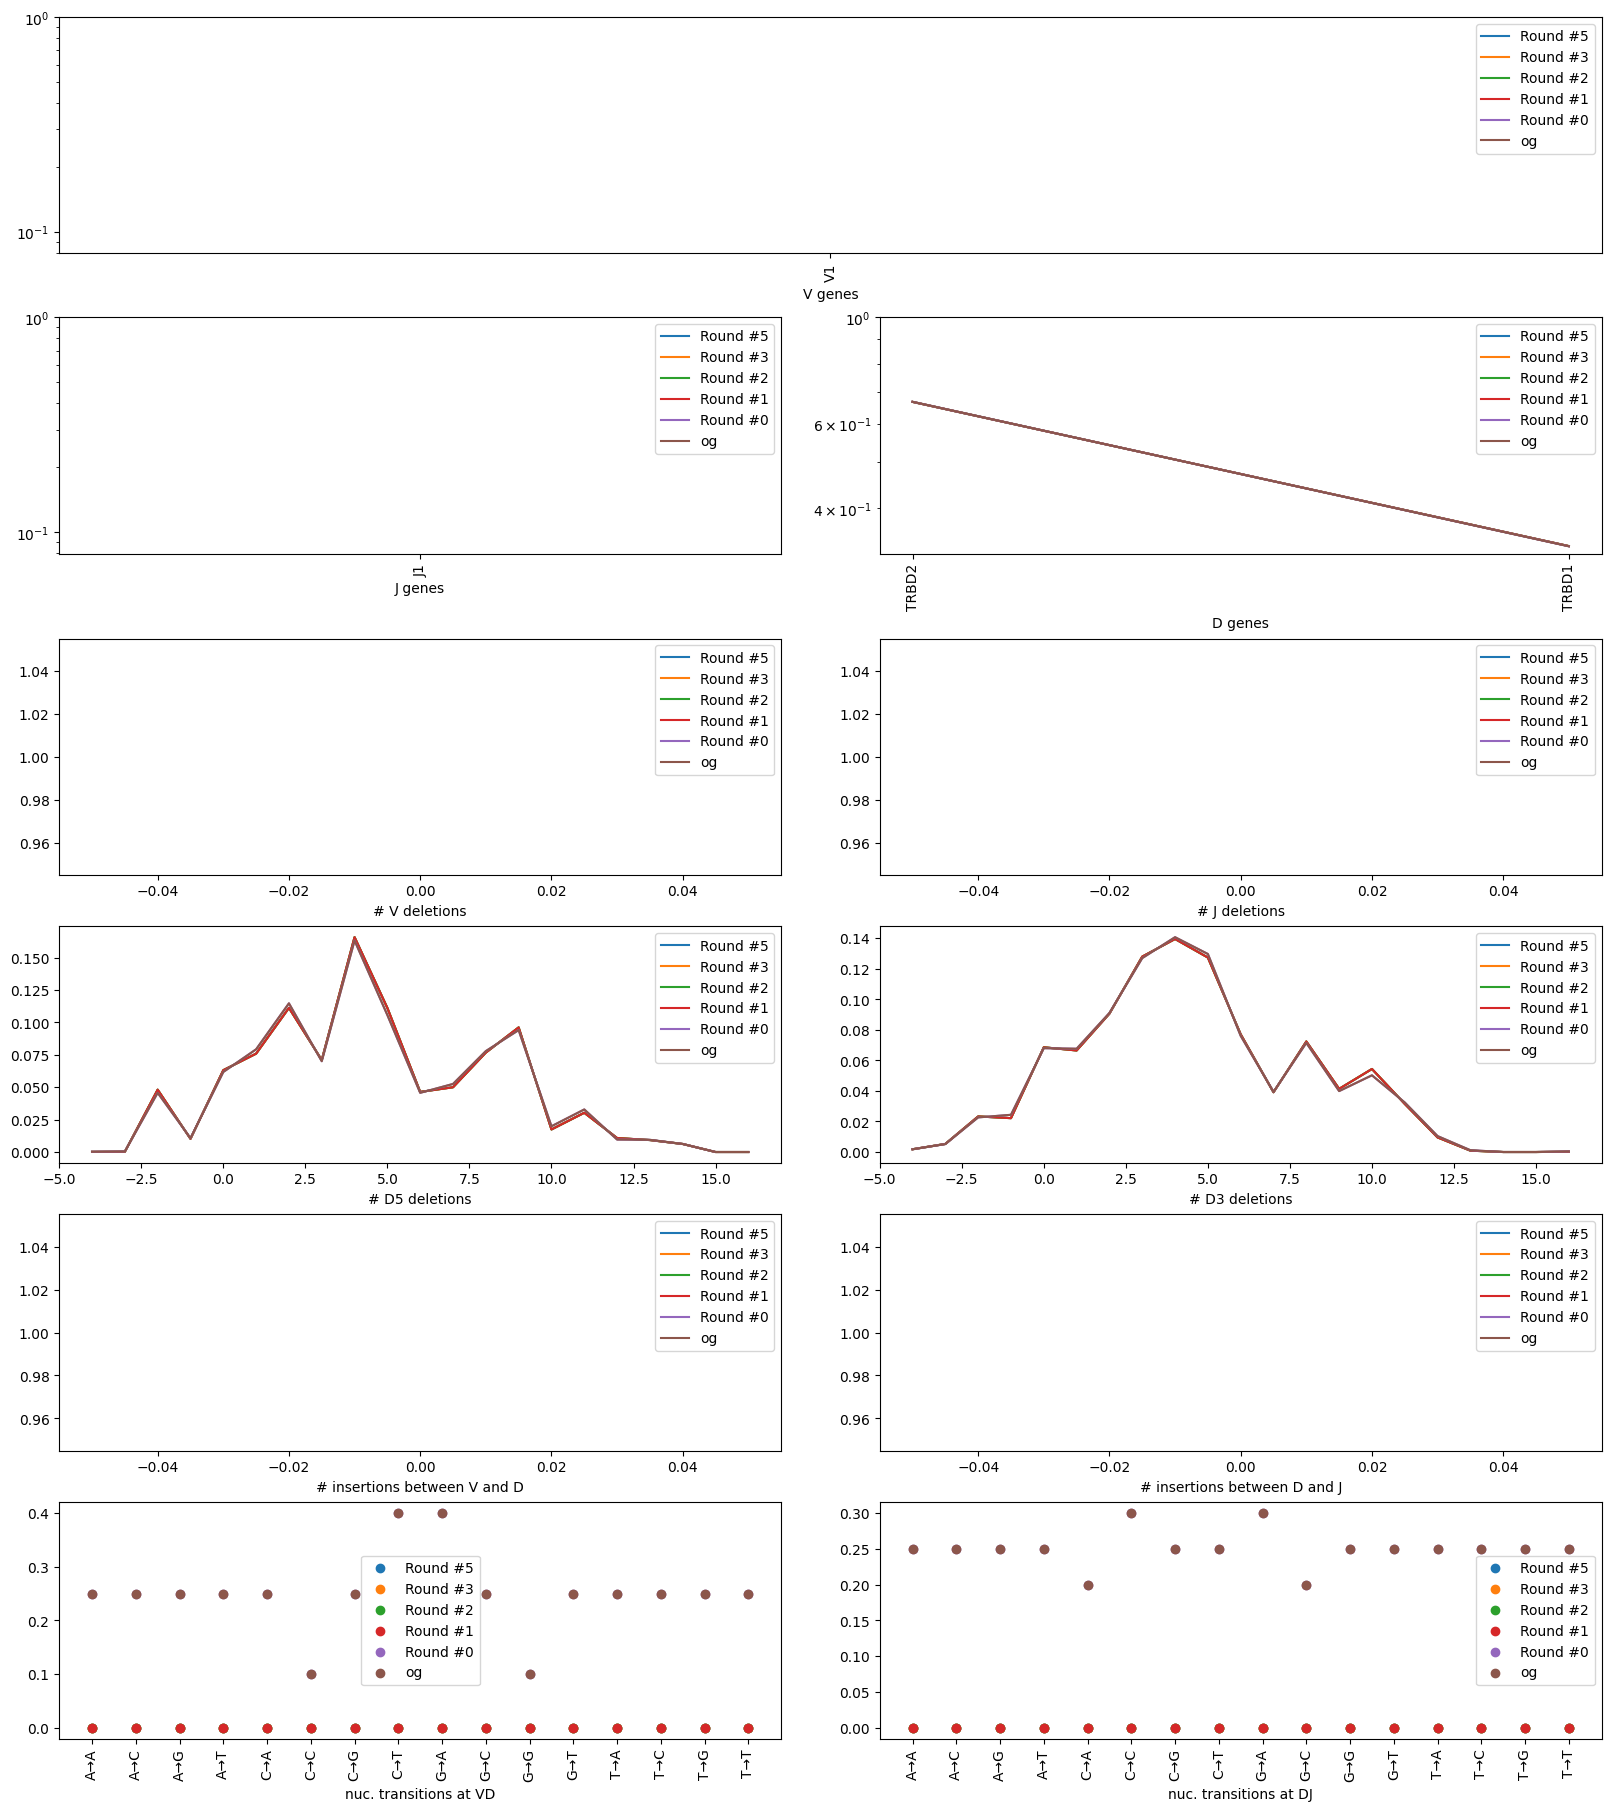

In [7]:
# visualisation of the results
fig = righor.plot_vdj(*[models[ii] for ii in [5, 3, 2, 1, 0]] + [igor_model],
            plots_kws=[{'label':f'Round #{ii}', 'alpha':1} for ii in [5, 3, 2, 1, 0]] + [{'label':f'og'}] )


In [8]:
model = igor_model.copy().uniform()

In [9]:
model.p_del_d5_del_d3

array([[[0.00226757, 0.00226757, 0.00226757],
        [0.00226757, 0.00226757, 0.00226757],
        [0.00226757, 0.00226757, 0.00226757],
        ...,
        [0.00226757, 0.00226757, 0.00226757],
        [0.00226757, 0.00226757, 0.00226757],
        [0.00226757, 0.00226757, 0.00226757]],

       [[0.00226757, 0.00226757, 0.00226757],
        [0.00226757, 0.00226757, 0.00226757],
        [0.00226757, 0.00226757, 0.00226757],
        ...,
        [0.00226757, 0.00226757, 0.00226757],
        [0.00226757, 0.00226757, 0.00226757],
        [0.00226757, 0.00226757, 0.00226757]],

       [[0.00226757, 0.00226757, 0.00226757],
        [0.00226757, 0.00226757, 0.00226757],
        [0.00226757, 0.00226757, 0.00226757],
        ...,
        [0.00226757, 0.00226757, 0.00226757],
        [0.00226757, 0.00226757, 0.00226757],
        [0.00226757, 0.00226757, 0.00226757]],

       ...,

       [[0.00226757, 0.00226757, 0.00226757],
        [0.00226757, 0.00226757, 0.00226757],
        [0.00226757, 0

In [40]:
generator = igor_model.generator()
example_seq = generator.generate(False)
sequences = [generator.generate(False).full_seq for _ in range(10000)]

align_params = righor.AlignmentParameters()
infer_params = righor.InferenceParameters()
# define parameters for the alignment and the inference 
# (can also be done for the evaluation)
# the default are generally fine
# longer V gene cut-off improve the alignment but slower
align_params.left_v_cutoff = 60
align_params.min_score_v = 100
align_params.max_error_d = 400

results = igor_model.evaluate(sequences, align_params=align_params, infer_params=infer_params)
Counter([a.best_event.d_index for a in results])

Counter({2: 3551, 0: 3297, 1: 3152})

In [41]:
a = results[0]
lst = [Counter([a.best_event.start_d - a.best_event.pos_d for a in results])[a] for a in range(19)]

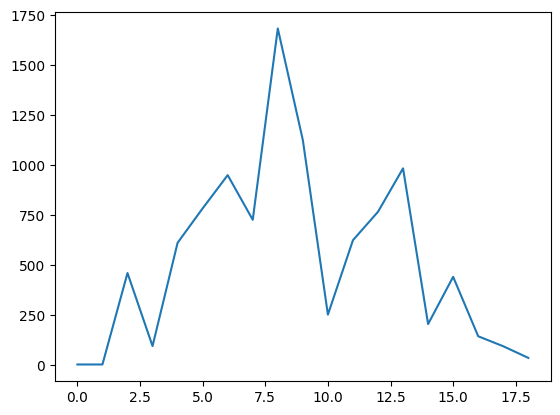

In [42]:
plt.plot(lst)

In [15]:
a = generator.generate(False)

gene = igor_model.d_segments[a.recombination_event.d_index].seq_with_pal

print(a.full_seq)
print('.'*(a.recombination_event.d_start_seq) + gene.get_string())
print(a.recombination_event.deld5)
print(a.recombination_event.deld3)

ATCTACTACTAATGCTTATGCGAAAAAAAAGGGGTGGGGGCAGTGTTCGGAGAAACAAAGACTTAT
.................TCCCGGGACTAGCGGGGGGGCCCC
13
7


In [7]:
Counter([generator.generate(False).recombination_event.deld5 for _ in range(10000)])

Counter({8: 1657,
         6: 1151,
         9: 1092,
         13: 959,
         5: 809,
         12: 737,
         7: 664,
         4: 571,
         11: 519,
         2: 473,
         10: 456,
         15: 326,
         14: 198,
         3: 124,
         17: 107,
         16: 82,
         18: 64,
         1: 8,
         0: 3})

In [53]:
results_al = [igor_model.align_sequence(a, align_params) for a in sequences]

In [94]:
Counter([min([(b.nb_errors(0, 0), b.index) for b in a.d_genes])[1] for a in results_al])

Counter({0: 901, 1: 93, 2: 6})

In [83]:
a = results_al[0]
b = a.d_genes[33]
b.index, b.pos

(0, 34)

In [84]:
print(sequences[0])
print('.'*34 + igor_model.d_segments[0].seq_with_pal.get_string())

ATCTACTACTACTGCTCATGCAAAAATCGGGGGGCAGTCTTCGGAGAAACAAAGACTTAT
..................................TCCCGGGACAGGGGGCGCCC


In [85]:
b = results_al[0].d_genes[33]
b.index, b.pos, b.nb_errors(2, 2)

(0, 34, 14)

In [19]:
igor_model.markov_coefficients_vd

array([[0.30947269, 0.24396976, 0.26487174, 0.18168582],
       [0.171005  , 0.44457   , 0.195512  , 0.188913  ],
       [0.23715724, 0.18413118, 0.37365537, 0.20505621],
       [0.232119  , 0.310102  , 0.196987  , 0.260792  ]])

In [18]:
models[18].markov_coefficients_vd

array([[0.31159057, 0.25188159, 0.2493728 , 0.18715504],
       [0.15832241, 0.43591088, 0.20707733, 0.19868938],
       [0.22542073, 0.17626218, 0.37599646, 0.22232064],
       [0.24612203, 0.30041365, 0.19027921, 0.26318511]])

In [11]:
# save the model in the Igor format (4 files in a directory)
# will return an error if the directory already exists
models[10].save_model('test_save')
# load the model
igor_model = righor.load_model_from_files(path_params='test_save/model_params.txt',
                                          path_marginals='test_save/model_marginals.txt',
                                          path_anchor_vgene='test_save/V_gene_CDR3_anchors.csv',
                                          path_anchor_jgene='test_save/J_gene_CDR3_anchors.csv')

# save the model in json format (1 file in a directory)
models[10].save_json('test_save.json')
# load the model in json
igor_model = righor.load_model_from_files(json='test_save.json')